# 📊 ***Data Science, CA2*** 📚

* **Member 1** : [Kasra Kashani, 810101490] 🆔
* **Member 2** : [Borna Foroohari, 810101480] 🆔

📄 **Subjects**: Visualition using Spark - Kafka

## 🔹**Imports**

Import required modules.

In [132]:
import pandas as pd
import json
import subprocess
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from confluent_kafka import Consumer, Producer
from datetime import datetime, timedelta
from dateutil.parser import isoparse
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, avg, count, when, col, to_timestamp, to_date, hour, dayofweek, udf, mean, stddev
from pyspark.sql.types import StringType
from pymongo import MongoClient

## 📍 **Main Task**

In [14]:
# A workaround for Jupyter Notebook to display long lines without wrapping
display(HTML('<style>pre { white-space: pre !important; }</style>'))

### 💡*Environment Setup & Data Ingestion Layer*

In the first part of the project, we implement a **Kafka consumer** and manage the schema. Data ingestion is the process of collecting data from sources into one single centralized system for analysis.

At first, we implement a function to validate each transaction against 3 basic business rules with error codes `ERR_AMOUNT`, `ERR_TIME` and `ERR_DEVICE`.

In [ ]:
def validate_transaction(trans, recieved_time):
    # Validate amount consistency
    try:
        total = trans['total_amount']
        amount = trans['amount']
        vat = trans['vat_amount']
        commission = trans['commission_amount']

        # Check the total amount
        if total != amount + vat + commission:
            return False, 'ERR_AMOUNT'
    except KeyError: # If the transaction doesn't include those fields
        return False, 'ERR_AMOUNT'

    # Validate time warping
    try:
        trans_time = isoparse(trans['timestamp']).replace(tzinfo=None)

        # Transaction time not in future
        if trans_time > recieved_time:
            return False, 'ERR_TIME'
        
        # Transaction time not more than a day older than Kafka ingestion time
        if trans_time < (recieved_time - timedelta(days=1)):
            return False, 'ERR_TIME'
    except KeyError: # If the transaction doesn't include that field
        return False, 'ERR_TIME'

    # Validate device mismatch
    try:
        pay_method = trans['payment_method']

        # check the mobile devices OS
        if pay_method == 'mobile':
            os = trans['device_info']['os']
            
            if os not in ['iOS', 'Android']:
                return False, 'ERR_DEVICE'
    except KeyError: # If the transaction doesn't include those fields
        return False, 'ERR_DEVICE'

    # Whenever the transaction is valid
    return True, None

Also we implement a function to create the error message for each invalid transaction by its error code.

In [16]:
def create_error_msg(trans, error_code, ingestion_time):
    # Specify the transaction id
    msg = {
        'transaction_id': trans['transaction_id'],
        'error_code': error_code
    }

    # Create the error message by the error code
    match error_code:
        case 'ERR_AMOUNT':
            try: msg['total_amount'] = trans['total_amount']
            except KeyError: msg['total_amount'] = None

            try: msg['amount'] = trans['amount']
            except KeyError: msg['amount'] = None

            try: msg['vat_amount'] = trans['vat_amount']
            except KeyError: msg['vat_amount'] = None

            try: msg['commission_amount'] = trans['commission_amount']
            except KeyError: msg['commission_amount'] = None
        case 'ERR_TIME':
            try: msg['timestamp'] = trans['timestamp']
            except KeyError: msg['timestamp'] = None

            msg['ingestion_time'] = ingestion_time.isoformat() + 'Z'
        case 'ERR_DEVICE':
            try: msg['payment_method'] = trans['payment_method']
            except KeyError: msg['payment_method'] = None

            try: msg['os'] = trans['device_info']['os']
            except KeyError: msg['os'] = None

    return msg

We need an appropriate data structure, such as pandas dataframe, for transaction events.

In [17]:
# Create a dataframe for the transactions
columns = ['transaction_id', 'timestamp', 'customer_id', 'merchant_id', 'merchant_category', 'payment_method', 'amount', 'location', 'device_info', 'status', 
           'commission_type', 'commission_amount', 'vat_amount', 'total_amount', 'customer_type', 'risk_level', 'failure_reason', 'validation']
df = pd.DataFrame(columns=columns)

Now, we create a Kafka consumer to connect to the Kafka server and read from the `darooghe.transactions` topic. Also we implement a proper deserialization like dictionaries for transactions. We also write all transactions that have been determined as invalid into the topic `darooghe.error_logs` as a Kafka producer. So we need to create a Kafka producer with that topic too.

In [18]:
# Set Kafka consumer configurations
config_cons = {
    'bootstrap.servers': 'localhost:9092', # Specify the port which Kafka is listening to
    'group.id': 'darooghe-group', # Unique ID to group consumers that share message load
    'auto.offset.reset': 'earliest' # Read messages from the beginning if no offset
}

# Set Kafka producer configurations
config_prod = {
    'bootstrap.servers': 'localhost:9092' # Specify the port which Kafka is listening to
}

# Build the Kafka consumer
consumer = Consumer(config_cons)

# Build the Kafka producer
producer = Producer(config_prod)

# Specify the consumer's topic
consumer.subscribe(['darooghe.transactions'])

print('\tListening for transactions...')

# Continuously listen to the topic and print each incoming message
transactions = []
printed = False
try:
    while True:
        # Poll for a new message for 1 second
        msg = consumer.poll(1.0)

        if msg is None:
            continue
        if msg.error():
            print(f'\tError: {msg.error()}')
        else:
            # Convert JSON messages to Python dictionaries
            transaction = json.loads(msg.value().decode('utf-8'))

            # Compute the current ingestion time
            ingestion_time = datetime.utcnow()

            # Print decoded message just once
            if not printed:
                print(f'An example transaction: {transaction}')
                printed = True

            # Validate the transaction
            valid, error_code = validate_transaction(transaction, ingestion_time)

            # Write invalid transactions into another topic
            if not valid:
                # Create the error message
                error_msg = create_error_msg(transaction, error_code, ingestion_time)

                # Write the message to the topic
                producer.produce(
                    topic='darooghe.error_logs', # Specify the producer's topic
                    value=json.dumps(error_msg).encode('utf-8') # Convert the Python dictionary to JSON messages
                )

                # Force Kafka to send all pending messages now
                producer.flush()

                # Set the transaction status to invalid
                transaction['validation'] = 'invalid'
            else:
                # Set the transaction status to valid
                transaction['validation'] = 'valid'

            # Add the transaction to the list
            transactions.append(transaction)
except KeyboardInterrupt:
    # Handle Ctrl+C
    print('\tStopped by user.')
finally:
    # Close the Kafka consumer
    consumer.close()


	Listening for transactions...


C:\Users\Asus\AppData\Local\Temp\ipykernel_20816\332206140.py:41: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ingestion_time = datetime.utcnow()


An example transaction: {'transaction_id': '2e1b5dcb-6f3e-47e3-b862-18c541f59005', 'timestamp': '2025-04-24T22:24:29.851410Z', 'customer_id': 'cust_155', 'merchant_id': 'merch_49', 'merchant_category': 'government', 'payment_method': 'pos', 'amount': 671074, 'location': {'lat': 35.733576942020136, 'lng': 51.372298548587295}, 'device_info': {}, 'status': 'declined', 'commission_type': 'progressive', 'commission_amount': 13421, 'vat_amount': 60396, 'total_amount': 744891, 'customer_type': 'business', 'risk_level': 3, 'failure_reason': 'system_error'}
	Stopped by user.


Now we add all transactions to a dataframe with their type conversions and validations, and then save them to a **csv file**.

In [19]:
# Add the transactions to the dataframe
for transaction in transactions:
    # Convert the transaction values to the appropriate types
    transaction['timestamp'] = pd.to_datetime(transaction['timestamp'], errors='coerce')
    transaction['amount'] = pd.to_numeric(transaction['amount'], errors='coerce')
    transaction['location'] = {'lat': float(transaction['location'].get('lat', 0.0)), 'lng': float(transaction['location'].get('lng', 0.0))}
    transaction['commission_amount'] = pd.to_numeric(transaction['commission_amount'], errors='coerce')
    transaction['vat_amount'] = pd.to_numeric(transaction['vat_amount'], errors='coerce')
    transaction['total_amount'] = pd.to_numeric(transaction['total_amount'], errors='coerce')
    
    # Concatenate the new transaction with the existing dataframe
    df = pd.concat([df, pd.DataFrame([transaction])], ignore_index=True)

# Display the dataframe with the transactions
df

C:\Users\Asus\AppData\Local\Temp\ipykernel_20816\935255840.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([transaction])], ignore_index=True)


,transaction_id,timestamp,customer_id,merchant_id,merchant_category,payment_method,amount,location,device_info,status,commission_type,commission_amount,vat_amount,total_amount,customer_type,risk_level,failure_reason,validation
0,2e1b5dcb-6f3e-47e3-b862-18c541f59005,2025-04-24 22:24:29.851410+00:00,cust_155,merch_49,government,pos,671074,"{'lat': 35.733576942020136, 'lng': 51.37229854...",{},declined,progressive,13421,60396,744891,business,3,system_error,invalid
1,045ad193-7c2c-4f04-97ff-44f037223997,2025-04-30 09:03:11.234952+00:00,cust_792,merch_15,entertainment,pos,150204,"{'lat': 35.74930608132483, 'lng': 51.289989449...",{},approved,progressive,3004,13518,166726,CIP,2,None,valid
2,0ae07577-7f06-4739-ac97-465d83cdd94c,2025-04-29 21:08:44.267608+00:00,cust_856,merch_26,government,pos,1043644,"{'lat': 35.766166975075826, 'lng': 51.36809825...",{},approved,tiered,20872,93927,1158443,business,2,None,valid
3,1bce1591-8a32-4957-a7e4-87add226acb3,2025-04-29 05:38:58.736436+00:00,cust_539,merch_5,entertainment,pos,1819342,"{'lat': 35.70864211834694, 'lng': 51.354367058...",{},approved,progressive,36386,163740,1983082,business,1,None,invalid
4,f842802c-4f6c-47a1-bafc-df3bf08a7f50,2025-04-25 11:16:14.277070+00:00,cust_229,merch_22,transportation,mobile,78966,"{'lat': 35.70859097440478, 'lng': 51.378055474...","{'os': 'iOS', 'app_version': '3.1.0', 'device_...",approved,tiered,1579,7106,87651,individual,1,None,invalid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20226,a5e485f3-069c-445a-8e5e-25000d276b3b,2025-04-30 16:07:10.228581+00:00,cust_712,merch_38,food_service,pos,1118889,"{'lat': 35.6902868868026, 'lng': 51.3623242736...",{},approved,flat,22377,100700,1219589,business,2,None,invalid
20227,ffac6446-d102-4838-8405-5660d57725ab,2025-04-30 16:07:10.670814+00:00,cust_343,merch_3,entertainment,online,1111604,"{'lat': 35.74941454441499, 'lng': 51.297457373...","{'os': 'Windows', 'app_version': '3.3.3', 'dev...",approved,flat,22232,100044,1211648,business,3,None,invalid
20228,e0a0f7cc-35c8-4de6-ba1a-ae63a2c00694,2025-04-30 16:07:11.026224+00:00,cust_477,merch_21,government,mobile,1841240,"{'lat': 35.6900440920389, 'lng': 51.3736254434...","{'os': 'Android', 'app_version': '2.4.1', 'dev...",approved,flat,36824,165711,2043775,business,3,None,valid
20229,e0066866-8585-48cb-b485-d3d660144557,2025-04-30 16:07:11.270462+00:00,cust_80,merch_44,transportation,nfc,1298966,"{'lat': 35.771150952977166, 'lng': 51.36524924...",{},approved,progressive,25979,116906,1441851,business,1,None,valid


In [20]:
# Save the dataframe to a CSV file
df.to_csv('transactions.csv', index=False)

### 💡*Batch Processing Layer*

In this part of the project, the focus is on processing and analyzing **existing data** that has already been generated, using **PySpark**. This task focuses on analyzing existing transactional data that has already been collected and stored. Using PySpark, the goal is to extract meaningful patterns, summaries, and insights from the **historical dataset** for further interpretation and visualization. 

So we first build a **Spark session** and read our transactions from the saved csv file into a Spark dataframe.

In [21]:
# Build a new Spark session
spark = SparkSession.builder \
    .appName('Commission Analysis Batch Job') \
    .getOrCreate()

# Read the CSV file into a Spark dataframe
df_spark = spark.read.option('header', True) \
    .option('inferSchema', True) \
    .csv('transactions.csv')

# Fix the commission amount for invalid transactions
df_spark = df_spark.withColumn(
    'commission_amount_fixed',
    when(
        (col('amount') + col('vat_amount') + col('commission_amount')) != col('total_amount'),
        0
    ).otherwise(
        col('commission_amount')
    )
)

#### I. Commission Analysis Batch Job

In this section, we get some insights from batch analysis of **transaction commissions**.

First we develop batch processing jobs that query aggregated data to generate reports on `commission` efficiency by `merchant category`.

As we can see in the result, in the batch analysis of transaction commissions across various merchant categories, we observe that:

- The highest total commissions are generated by the `transportation` and `retail` categories, indicating their strong contribution to overall platform revenue.

- Also `government` had the highest average commission per transaction and also ranked highest in commission to transaction ratio, making it the most profitable category per transaction.

- We can see that `entertainment` transactions shows the lowest total commissions, lowest average per transaction, and low commission ratio, marking it as the least profitable category.

- Categories like `food service` performed moderately in all metrics, suggesting consistent but less impactful revenue contribution.

In [22]:
# Commission analysis for each merchant category
df_commission = df_spark.groupBy('merchant_category').agg(
    sum('commission_amount').alias('total_commission'),
    avg('commission_amount').alias('average_commission'),
    (sum('commission_amount_fixed') / count('*')).alias('commission_to_transaction_ratio')
)

# Show the commission analysis results
df_commission.show(truncate=False)

+-----------------+----------------+------------------+-------------------------------+
|merchant_category|total_commission|average_commission|commission_to_transaction_ratio|
+-----------------+----------------+------------------+-------------------------------+
|retail           |83372863        |20494.804080629303|16348.80162241888              |
|entertainment    |80734450        |20392.637029552916|16184.509472088912             |
|food_service     |83130823        |20445.357353664534|16147.136989670438             |
|government       |82803495        |20582.52423564504 |16540.02759134974              |
|transportation   |84437109        |20519.346051032808|16387.16063183475              |
+-----------------+----------------+------------------+-------------------------------+



Now we want to identify optimal `commission structures`, according to each `merchant category`.

We can observe that:

- For `entertainment`, **flat** performs best with the highest average commission.

- For `food service`, **progressive** delivers the highest profit per transaction.

- For `government`, **progressive** leads in both average and total commission and alsoin commission ratio.

- For `retail`, **tiered** offers the highest efficiency and average commission.

- For `transportation`, **tiered** achieves a good overall performance.

In [23]:
# Commission model analysis for each merchant category and commission type
df_commission_model = df_spark.groupBy('merchant_category', 'commission_type').agg(
    sum('commission_amount').alias('total_commission'),
    avg('commission_amount').alias('average_commission'),
    (sum('commission_amount_fixed') / count('*')).alias('commission_to_transaction_ratio')
).orderBy('merchant_category', 'commission_type')

# Show the commission model analysis results
df_commission_model.show(truncate=False)

+-----------------+---------------+----------------+------------------+-------------------------------+
|merchant_category|commission_type|total_commission|average_commission|commission_to_transaction_ratio|
+-----------------+---------------+----------------+------------------+-------------------------------+
|entertainment    |flat           |27490582        |20623.09227306827 |16589.013503375845             |
|entertainment    |progressive    |27020669        |20392.957735849057|16171.676981132076             |
|entertainment    |tiered         |26223199        |20156.18677940046 |15783.125288239815             |
|food_service     |flat           |27883094        |20352.623357664233|16176.610218978101             |
|food_service     |progressive    |28797025        |20807.098988439306|16566.407514450868             |
|food_service     |tiered         |26450704        |20160.59756097561 |15674.081554878048             |
|government       |flat           |27012904        |20325.736644

Then we use historical commission data to analyze trends and simulate different commission models.

As a result, an analysis of historical commission data across different merchant categories reveals the following key trends:

- `Entertainment` & `Retail` ->
showed strong commission performance, especially in the early days. 

- `Food service` ->
Started strong but showed a steady decline in both commissions and transaction value after April 27.

- `Government` ->
Had the most stable commission to transaction ratios, indicating consistent efficiency.

- `Retail` ->
Generally stable with a moderate upward trend, particularly around April 25–26. This suggests healthy growth.

- `Transportation` ->
Had steady transaction volumes but lacks commission data, suggesting either minimal commissions or missing records.

In [24]:
# Add a timestamp and date column to the dataframe
df_time = df_spark.withColumn('timestamp', to_timestamp('timestamp')) \
                  .withColumn('date', to_date('timestamp'))

# Commission trend analysis for each merchant category and date
df_commission_trend = df_time.groupBy('merchant_category', 'date').agg(
    sum('commission_amount').alias('total_commission'),
    avg('commission_amount').alias('average_commission'),
    (sum('commission_amount_fixed') / count('*')).alias('commission_to_transaction_ratio')
).orderBy('merchant_category', 'date')

# Show the commission model trend analysis results
df_commission_trend.show(40, truncate=False)

+-----------------+----------+----------------+------------------+-------------------------------+
|merchant_category|date      |total_commission|average_commission|commission_to_transaction_ratio|
+-----------------+----------+----------------+------------------+-------------------------------+
|entertainment    |2025-04-23|2222407         |22004.029702970296|17209.564356435643             |
|entertainment    |2025-04-24|10786772        |20864.16247582205 |16984.363636363636             |
|entertainment    |2025-04-25|11175415        |20135.882882882885|16644.326126126125             |
|entertainment    |2025-04-26|11310397        |19877.674868189806|15309.773286467487             |
|entertainment    |2025-04-27|11667927        |20256.817708333332|15633.678819444445             |
|entertainment    |2025-04-28|11924908        |20041.86218487395 |16094.857142857143             |
|entertainment    |2025-04-29|11442207        |20841.907103825135|16437.6247723133               |
|entertain

As we can see, an analysis of historical commission data across different commission models reveals that:

- Among the three commission models, all show relatively similar total commissions across the week. However, the `tiered` model consistently delivers the highest commission to transaction ratios, indicating better efficiency. The `flat` model remains stable but slightly less efficient overall, while the `progressive` model maintains a balance between total volume and per transaction profitability.  

In [25]:
# Commission model trend analysis for each commission type and date
df_commission_model_trend = df_time.groupBy('commission_type', 'date').agg(
    sum('commission_amount').alias('total_commission'),
    avg('commission_amount').alias('average_commission'),
    (sum('commission_amount_fixed') / count('*')).alias('commission_to_transaction_ratio')
).orderBy('commission_type', 'date')

# Show the commission model trend analysis results
df_commission_model_trend.show(24, truncate=False)

+---------------+----------+----------------+------------------+-------------------------------+
|commission_type|date      |total_commission|average_commission|commission_to_transaction_ratio|
+---------------+----------+----------------+------------------+-------------------------------+
|flat           |2025-04-23|3427891         |21291.24844720497 |17098.75155279503              |
|flat           |2025-04-24|19947969        |20396.696319018403|16011.005112474437             |
|flat           |2025-04-25|18687869        |20423.900546448087|16821.041530054645             |
|flat           |2025-04-26|19817565        |20367.487153134636|16529.132579650566             |
|flat           |2025-04-27|19474738        |20265.07596253902 |15572.260145681581             |
|flat           |2025-04-28|21124116        |20791.452755905513|16743.327755905513             |
|flat           |2025-04-29|18950401        |20181.47071352503 |16314.119275825346             |
|flat           |2025-04-30|17

#### II. Transaction Pattern Analysis

In this part, we analyze transactions pattern to discover **time-based trends**, **customer behavior patterns**, and **differences across merchant categories**.

First, we discover some temporal patterns in transaction data and identify peak transaction times based on historical data.

We can observe that:

- `Hourly`: Transactions are fairly consistent throughout the day, but peak activity occurs at 19:00 with 1,100 transactions, indicating evening as the busiest period. Hours like 14:00, 9:00, and 16:00 also show high volume, while early morning hours (1–6 AM) have relatively lower but still steady counts.

- `Daily`: Transactions are evenly distributed across the week. Thursday has the highest activity with 3,034 transactions, followed closely by Tuesday and Monday. Saturday shows the lowest count, which may suggest reduced weekend activity.

In [26]:
# Extract hour and day of transactions
df_time = df_time.withColumn('hour', hour('timestamp')) \
                 .withColumn('day_of_week', dayofweek('timestamp'))

# Trend analysis for each day
df_day_trend = df_time.groupBy('day_of_week').agg(
    count('*').alias('transaction count')
).orderBy('day_of_week')

# Trend analysis for each hour
df_hour_trend = df_time.groupBy('hour').agg(
    count('*').alias('transaction count')
).orderBy('hour')

# Show the day and hour trend analysises results
df_day_trend.show(truncate=False)
df_hour_trend.show(24, truncate=False)

+-----------+-----------------+
|day_of_week|transaction count|
+-----------+-----------------+
|1          |2930             |
|2          |2947             |
|3          |2857             |
|4          |3034             |
|5          |2881             |
|6          |2749             |
|7          |2833             |
+-----------+-----------------+

+----+-----------------+
|hour|transaction count|
+----+-----------------+
|0   |839              |
|1   |811              |
|2   |792              |
|3   |808              |
|4   |844              |
|5   |823              |
|6   |794              |
|7   |864              |
|8   |812              |
|9   |860              |
|10  |834              |
|11  |834              |
|12  |837              |
|13  |781              |
|14  |867              |
|15  |823              |
|16  |860              |
|17  |848              |
|18  |836              |
|19  |1100             |
|20  |850              |
|21  |856              |
|22  |826             

Now, we segment customers based on spending frequency to 3 partitions `high frequency`, `medium frequency`, and `low frequency`.

As a result:
- Out of all customers, the majority fall into the `medium frequency` group, indicating they engage fairly regularly with the service. A notable portion are `high frequency` users, suggesting a strong, loyal customer base with repeated activity. Meanwhile, only a small group are `low frequency` users, which could represent new, inactive, or disengaged customers.

In [41]:
# Transaction frequency analysis for each customer
df_customer_frequency = df_spark.groupBy('customer_id').agg(
    count('*').alias('transaction_count')
)

# Partition customers based on their transaction count
df_segmented_customers = df_customer_frequency.withColumn(
    'frequency_segment',
    when(col('transaction_count') >= 25, 'high frequency')
    .when(col('transaction_count') >= 13, 'medium frequency')
    .otherwise('low frequency')
)

# Frequency segment analysis for each segmentation
df_segmented_customers = df_segmented_customers.groupBy('frequency_segment').count()

# Show the segmented customer analysis results
df_segmented_customers.show(truncate=False)

+-----------------+-----+
|frequency_segment|count|
+-----------------+-----+
|low frequency    |35   |
|medium frequency |805  |
|high frequency   |160  |
+-----------------+-----+



Now we want to compare transaction behavior across different merchant categories.

The results of analysis of transaction behavior across merchant categories shows that:

- `Transportation` leads with the highest total transaction value and transaction count, indicating frequent usage and strong revenue generation.
- `Retail` and `food service` closely follow, both with over 4060 transactions and solid total amounts.
- Although `entertainment` has the lowest transaction count, it maintains a high average transaction value, reflecting higher-value purchases.
- `Government` services are also notable for their stability and average value, contributing significantly to overall volume.


**Overall, `Transportation` leads in both volume and value, while all other categories show balanced spending patterns, indicating overall consistent customer behavior across sectors.**

In [42]:
# Merchant category behavior analysis for each category
df_category_behavior = df_spark.groupBy('merchant_category').agg(
    count('*').alias('transaction count'),
    avg('amount').alias('average amount'),
    sum('amount').alias('total amount'),
)

# Show the category behavior analysis results
df_category_behavior.show(truncate=False)

+-----------------+-----------------+------------------+------------+
|merchant_category|transaction count|average amount    |total amount|
+-----------------+-----------------+------------------+------------+
|retail           |4068             |1024764.8001474927|4168743207  |
|entertainment    |3959             |1019656.1495327103|4036818696  |
|food_service     |4066             |1022291.9623708805|4156639119  |
|government       |4023             |1029150.5297042008|4140272581  |
|transportation   |4115             |1025991.9215066829|4221956757  |
+-----------------+-----------------+------------------+------------+



Then, we identify when most transactions happen, at `morning`, `afternoon`, `evening` or `night`.

We can observe that:

- Transactions are well distributed across all time segments, with `evening` slightly outperforming others, suggesting peak user engagement during post work hours. `Afternoon` and `morning` show similar levels of activity, while `night` has the lowest volume, though not by a wide margin.

In [43]:
# Partition the day into four segmentation
df_period = df_time.withColumn(
    'day_period',
    when(col('hour').between(6, 11), 'morning')
    .when(col('hour').between(12, 17), 'afternoon')
    .when(col('hour').between(18, 23), 'evening')
    .otherwise('night')
)

# Day period analysis for each period
df_day_period = df_period.groupBy('day_period').count().orderBy('day_period')

# Show the day period analysis results
df_day_period.show(truncate=False)

+----------+-----+
|day_period|count|
+----------+-----+
|afternoon |5016 |
|evening   |5300 |
|morning   |4998 |
|night     |4917 |
+----------+-----+



And then, we notice if people are spending more or less over time.

So that:

- Transaction activity remained relatively stable from `April 22 to April 28`, peaking on `April 24`. The average transaction amount also stayed consistent, except on `April 27`, which saw a noticeable dip in average value, possibly due to low value purchases or promotions. On `April 29`, transaction volume dropped drastically to just 18, despite having the highest average amount, indicating a potential system issue, partial data, or an anomaly that needs investigation.

In [44]:
# Spending trend analysis for each date
df_spending_trend = df_time.groupBy('date').agg(
    count('*').alias('transaction count'),
    avg('amount').alias('average amount'),
).orderBy('date')

# Show the spending trend analysis results
df_spending_trend.show(truncate=False)

+----------+-----------------+------------------+
|date      |transaction count|average amount    |
+----------+-----------------+------------------+
|2025-04-23|501              |1052057.2155688624|
|2025-04-24|2881             |1034224.7094758764|
|2025-04-25|2749             |1030332.0894870862|
|2025-04-26|2833             |1020641.2230850689|
|2025-04-27|2930             |1023212.1160409556|
|2025-04-28|2947             |1019380.3013233797|
|2025-04-29|2857             |1015690.804340217 |
|2025-04-30|2533             |1022477.2727990525|
+----------+-----------------+------------------+



#### III. Data Storage Implementation

In the last section of this part, we load our dataset into **MongoDB** and use its queries to summarize key insights.

First, we build a client and connect to it and then load our `transactions.csv` dataset into MongoDB.

In [48]:
# Build a client object to connect to the MongoDB
client = MongoClient('mongodb://localhost:27017')

# Create the database
db = client['transactions_db']

# Select a table from the database to write our queries on that
table = db['transactions_table']

# Read the csv file into a dataframe
df = pd.read_csv('transactions.csv')

# Convert timestamo column to the date format if it is not
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Concert the dataframe to a list of dictionaries so tha MongoDB could read it
dataset = df.to_dict('records')

# Load our whole dataset into a table in MongoDB
table.insert_many(dataset)

InsertManyResult([ObjectId('681258f9e71ed24df2cf45fa'), ObjectId('681258f9e71ed24df2cf45fb'), ObjectId('681258f9e71ed24df2cf45fc'), ObjectId('681258f9e71ed24df2cf45fd'), ObjectId('681258f9e71ed24df2cf45fe'), ObjectId('681258f9e71ed24df2cf45ff'), ObjectId('681258f9e71ed24df2cf4600'), ObjectId('681258f9e71ed24df2cf4601'), ObjectId('681258f9e71ed24df2cf4602'), ObjectId('681258f9e71ed24df2cf4603'), ObjectId('681258f9e71ed24df2cf4604'), ObjectId('681258f9e71ed24df2cf4605'), ObjectId('681258f9e71ed24df2cf4606'), ObjectId('681258f9e71ed24df2cf4607'), ObjectId('681258f9e71ed24df2cf4608'), ObjectId('681258f9e71ed24df2cf4609'), ObjectId('681258f9e71ed24df2cf460a'), ObjectId('681258f9e71ed24df2cf460b'), ObjectId('681258f9e71ed24df2cf460c'), ObjectId('681258f9e71ed24df2cf460d'), ObjectId('681258f9e71ed24df2cf460e'), ObjectId('681258f9e71ed24df2cf460f'), ObjectId('681258f9e71ed24df2cf4610'), ObjectId('681258f9e71ed24df2cf4611'), ObjectId('681258f9e71ed24df2cf4612'), ObjectId('681258f9e71ed24df2cf46

Then we use a proper partitioning and indexing strategy by `timestamp` and `merchant category` to ensure efficient querying and scalability, because we will work on these fields a lot and want to have a efficient and quick searches on these fields.

In [49]:
# Partition and index our table
timestamp_index = table.create_index('timestamp')
merchant_index = table.create_index('merchant_category')

# Show the index name of these two partition fields
print(timestamp_index)
print(merchant_index)

timestamp_1
merchant_category_1


Now we want to implement some data retention policy, so that we keep the last 24 hours of detailed data and delete the other ones.

In [50]:
# Specify the time for 24 hour before
cutoff_time = ingestion_time - timedelta(hours=24)

# Delete all data before Kafka ingestion time
deleted = table.delete_many({ 'timestamp': { '$lt': cutoff_time } })

# Show the number of deleted rows
print(f'{deleted.deleted_count} rows deleted.')

17168 rows deleted.


In the last section of this part, we create aggregated historical datasets for longer term analysis using MongoDB queris.


First we summarize our transaction data and group transactions daily by `timestamp` and `merchant category` using a aggregation pipeline, a set of operations that apply on the data. Also we aggregate total commissions earned per merchant category over time.

In [60]:
# Create the query pipeline
pipeline = [
    {
        '$group': {
            '_id': {
                'date': { '$dateToString': { 'format': '%Y-%m-%d', 'date': '$timestamp' } }, # Group data by date and merchant category
                'merchant_category': '$merchant_category',
                'commission_type': '$commission_type'
            },
            'transaction_count': { '$sum': 1 }, # Compute and save these 3 statistics on our data
            'average_amount': { '$avg': '$amount' },
            'average_commission': { '$avg': '$commission_amount' },
            'commission_amount': { '$sum': '$commission_amount' },
            'amount': { '$sum': '$amount' },
            'total_amount': { '$sum': '$total_amount' },
            'amount': { '$sum': '$amount' }
        }
    },
    {
        '$addFields': {
            'commission_to_transaction_ratio': { # Compute the commission ratio
                '$cond': [
                    { '$eq': ['$transaction_count', 0] },
                    0,
                    { '$divide': ['$commission_amount', '$transaction_count'] }
                ]
            }
        }
    },
    {
        '$project': {
            '_id': 0, # Delet _id column which is not needed in our dataset
            'date': "$_id.date",
            'merchant_category': '$_id.merchant_category',
            'commission_type': '$_id.commission_type',
            'transaction_count': 1,
            'average_amount': 1,
            'average_commission': 1,
            'commission_amount': 1,
            'amount': 1,
            'total_amount': 1,
            'amount': 1,
            'commission_to_transaction_ratio': 1
        }
    },
    {
        '$out': 'daily_transaction_summary' # Save this summarized output in a table
    }
]

# Apply the pipeline query on our dataset table
table.aggregate(pipeline)

### 💡*Real-Time Processing Layer*

In this part of the project, the focus is on processing incoming data in **real-time** as it arrives, rather than working with pre-existing or historical data in the dataset. The goal is to analyze the stream of new transactions from Kafka continuously. This task focuses on analyzing incoming transaction data from Kafka in real time, rather than historical data. The goal is to extract time-based insights as new data flows in.

***NOTICE THAT THE CODE IMPLEMENTATION OF THIS PART IS IN 3 SEPERATED .py FILES.***

#### I. Spark Streaming Application

***`Spark_Streaming_Application.py`***

In the first section, we generate **live insights** such as merchant activity trends, to enable timely decision-making based on current transaction data streams.

1. First, we implement a **Spark streaming application** that connects to Kafka consumer and read data from the Kafka topic `darooghe.transactions`. Then Kafka messages are **parsed** into structured columns (JSON) using a defined **schema**.

2. Next, we use **windowed aggregations**, so that our system performs **micro-batch processing** with 1 minute windows and 20 second sliding intervals.

3. Then we implement a **checkpoint mechanism** for fault tolerance. 

At the end, real-time results are printed to the console and aggregated insights are also sent back to Kafka (`darooghe.streamApp.minute`) for further use.

In [ ]:
# Show the results of this section
process = subprocess.Popen(
    ['python', 'Spark_Streaming_Application.py'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

for line in process.stdout:
    print(line, end="")

:: loading settings :: url = jar:file:/F:/python/Lib/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: C:\Users\Asus\.ivy2\cache
The jars for the packages stored in: C:\Users\Asus\.ivy2\jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-97dda45b-ef93-420f-b9a5-9f67abff884f;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.0 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#js

#### II. Fraud Detection System

***`Fraud_Detection_System.py`***

In this section, we implement three **fraud detection rules** `velocity check`, `geographical impossibility` and `amount anomal`. Incoming transactions from Kafka are continuously monitored for suspicious activity based on these three rules.

Also we write detected fraud events to the `darooghe.fraud_alerts` topic.

In [ ]:
# Show the results of this section
process = subprocess.Popen(
    ['python', 'Fraud_Detection_System.py'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

for line in process.stdout:
    print(line, end="")

:: loading settings :: url = jar:file:/F:/python/Lib/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: C:\Users\Asus\.ivy2\cache
The jars for the packages stored in: C:\Users\Asus\.ivy2\jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-61ffbf94-e0da-4cf7-b42f-74a651b639b1;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.0 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#js

#### III. Real-Time Commission Analytics

***`Real-Time_Commission_Analytics.py`***

At the end of this section, we calculate and write real-time metrics for commissions in the `darooghe.commission_analytic` topic. This task involves building a real-time analytics pipeline to monitor and extract insights about transaction **commissions** as they occur. These metrics are:

1. Total commission by type per minute.

2. Commission ratio (commission/transaction amount) by merchant category.

3. Highest commission-generating merchants in 5-minute windows.

In [23]:
# Show the results of this section
process = subprocess.Popen(
    ['python', 'Real-Time_Commission_Analytics.py'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

for line in process.stdout:
    print(line, end="")

:: loading settings :: url = jar:file:/F:/python/Lib/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: C:\Users\Asus\.ivy2\cache
The jars for the packages stored in: C:\Users\Asus\.ivy2\jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4d60c234-a8df-4234-98df-083eb5d3e63c;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.0 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#js

### 💡*Visualization*

In the last part of the project, we extract some **key insights** from the data using the **MatPlotLib** visualization library.

First, load the `historical transactions` data from CSV file into a dataframe.

In [24]:
# Read the historical transactions from the CSV file
df_historical = pd.read_csv('transactions.csv', parse_dates=["timestamp"])

Then, we consume and convert `real-time transactions` from Kafka Topics into a dataframe.

In [29]:
def read_real_time_transactions(topic):
    # Set Kafka consumer configurations
    config_cons = {
        'bootstrap.servers': 'localhost:9092', # Specify the port which Kafka is listening to
        'group.id': f'{topic}-group', # Unique ID to group consumers that share message load
        'auto.offset.reset': 'earliest', # Read messages from the beginning if no offset
        'enable.auto.commit': False, # Disable auto-commit of offsets
    }

    # Build the Kafka consumer
    consumer = Consumer(config_cons)

    # Specify the consumer's topic
    consumer.subscribe([topic])
    consumer.poll(1.0)

    print('\tListening for transactions...')

    # Continuously listen to the topic and save each incoming message
    transactions = []
    count = 0
    try:
        while True:
            # Poll for a new message for 1 second
            msg = consumer.poll(1.0)

            if msg is None:
                if count >= 10:
                    break
                count += 1
                continue
            if msg.error():
                print(f'\tError in topic {topic}: {msg.error()}')
            else:
                count = 0
                
                # Convert JSON messages to Python dictionaries
                transaction = json.loads(msg.value().decode('utf-8'))

                # Add the transaction to the list
                transactions.append(transaction)
    except KeyboardInterrupt:
        # Handle Ctrl+C
        print('\tStopped by user.')
    finally:
        # Close the Kafka consumer
        consumer.close()

    # Convert the list of real-time transactions to a dataframe and rutern them
    return pd.json_normalize(transactions) if transactions else pd.DataFrame()

In [32]:
# Specify all our real-time topics
topics = ['darooghe.spark_streaming', 'darooghe.fraud_alerts', 'darooghe.commission.total', 'darooghe.commission.ratio', 'darooghe.commission.highest']

df_real_time = {}

for topic in topics:
    print(f'Consume from topic: {topic}')

    # Read from this topic into a dataframe
    df = read_real_time_transactions(topic)

    # Save this dataframe in the dictionary with the topic name as the key
    df_real_time[topic] = df 

# Check if we read correctly
for key, value in df_real_time.items():
    print(f'\n\tFor topic {key}:')
    print(value.head(5))

Consume from topic: darooghe.spark_streaming
	Listening for transactions...
Consume from topic: darooghe.fraud_alerts
	Listening for transactions...
Consume from topic: darooghe.commission.total
	Listening for transactions...
Consume from topic: darooghe.commission.ratio
	Listening for transactions...
Consume from topic: darooghe.commission.highest
	Listening for transactions...

	For topic darooghe.spark_streaming:
Empty DataFrame
Columns: []
Index: []

	For topic darooghe.fraud_alerts:
Empty DataFrame
Columns: []
Index: []

	For topic darooghe.commission.total:
Empty DataFrame
Columns: []
Index: []

	For topic darooghe.commission.ratio:
Empty DataFrame
Columns: []
Index: []

	For topic darooghe.commission.highest:
Empty DataFrame
Columns: []
Index: []


#### I. Transactions Volume

In the first metric that we check, we display time-series charts that show **real-time** and **historical** transaction volumes, helping to identify **trends and seasonal peaks**.

First we plot a time-series for historical transactions volumes group by each day. We can see that:
- **This chart shows that daily transaction volume surged sharply on April 24 and remained consistently high through April 29, suggesting sustained platform engagement. However, a noticeable drop on April 30 may indicate a temporary decline in user activity or a weekend/holiday effect worth investigating.**

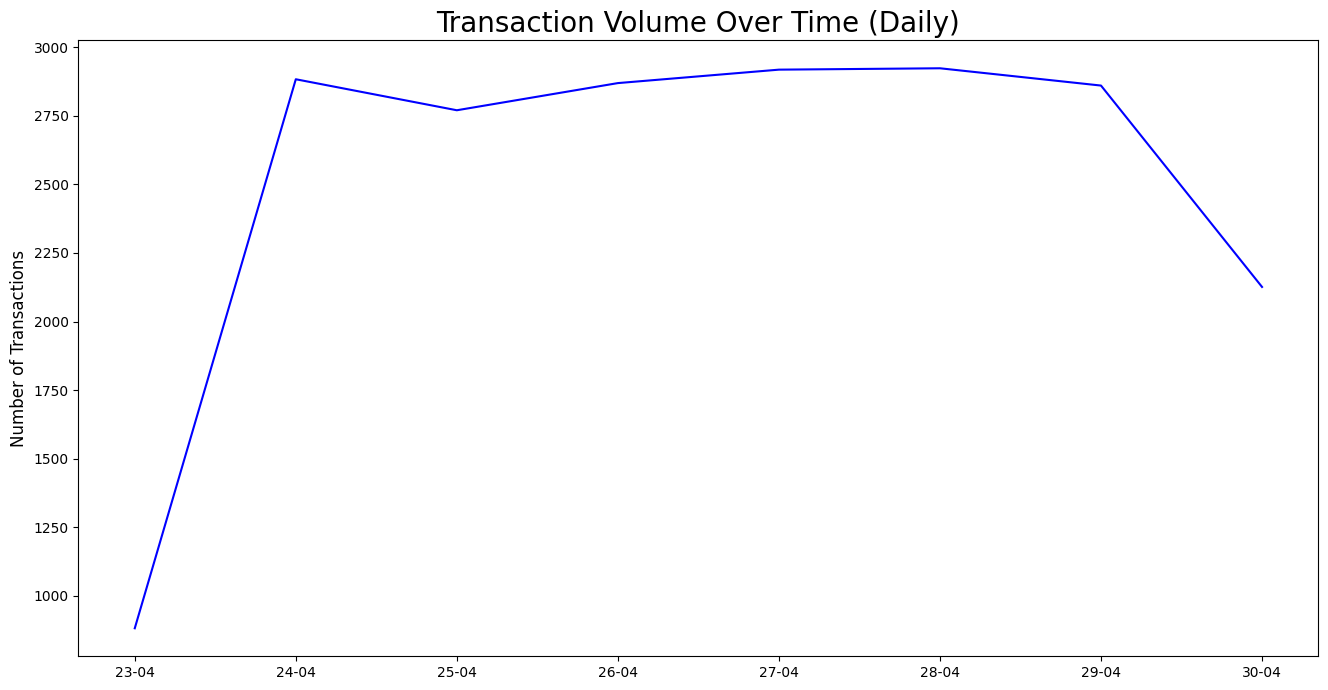

In [ ]:
# Group the transactions by day and count the number of transactions per day
df_historical['day'] = df_historical['timestamp'].dt.date
volume_daily = df_historical.groupby('day').size().reset_index(name='transaction_count')

# Convert the day column to a string format for better visualization
volume_daily['day_str'] = volume_daily['day'].apply(lambda x: x.strftime('%d-%m'))

# Show the daily transactions volume plot
plt.figure(figsize=(16, 8))
plt.plot(volume_daily['day_str'], volume_daily['transaction_count'], color='b')
plt.title('Transaction Volume Over Time (Daily)', fontsize=20)
plt.ylabel('Number of Transactions', fontsize=12)

plt.show()

#### II. Merchant Analysis

In this metric, we show the top 5 merchants based on the **number of transactions**.

First we plot a bar plot for historical transactions merchant analysis. As a result:

- **This bar chart shows that the top 5 merchants have very close transaction volumes, each contributing significantly to platform activity. It suggests a well-balanced merchant ecosystem without over-reliance on a single vendor, which is healthy for operational stability.**

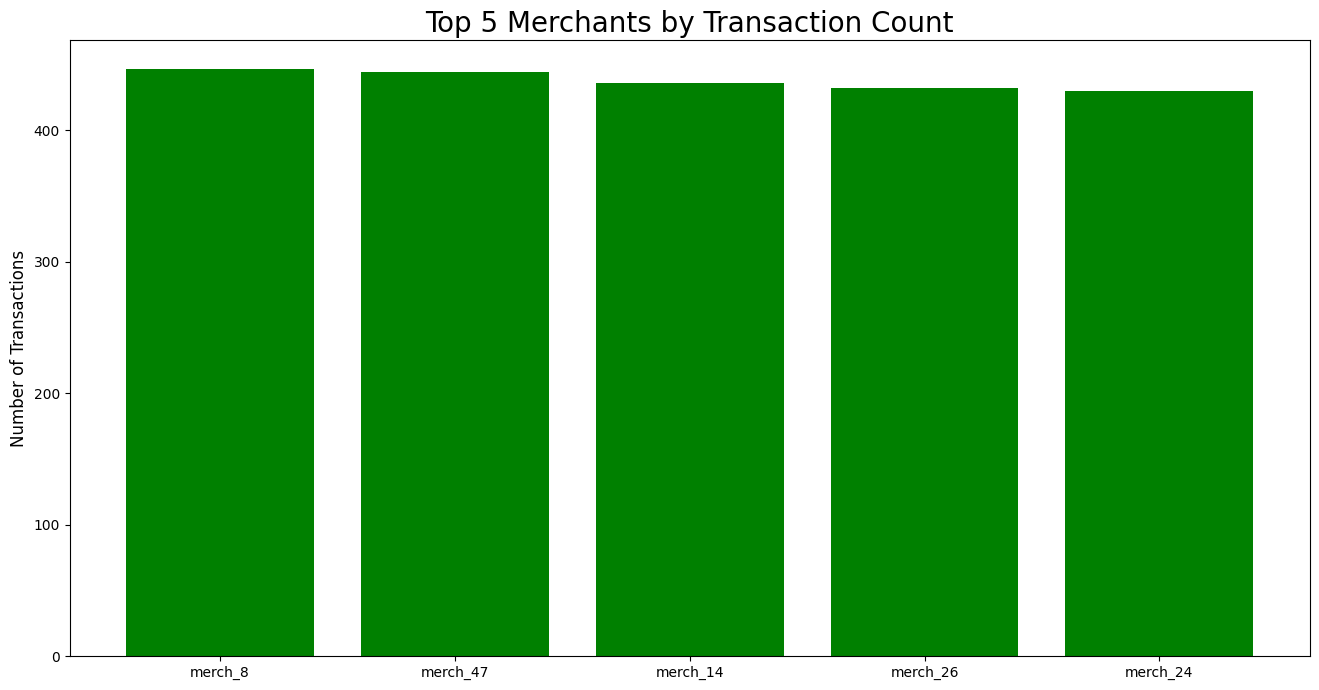

In [82]:
# Group the transactions by merchants and count the number of transactions for each merchant
merchant_transactions = df_historical.groupby('merchant_id').size().reset_index(name='transaction_count')

# Select the top 5 merchants with the highest transaction count
top_5_merchants = merchant_transactions.sort_values(by='transaction_count', ascending=False).head(5)

# Show the merchant analysis plot
plt.figure(figsize=(16, 8))
plt.bar(top_5_merchants['merchant_id'].astype(str), top_5_merchants['transaction_count'], color='green')
plt.title('Top 5 Merchants by Transaction Count', fontsize=20)
plt.ylabel('Number of Transactions', fontsize=12)

plt.show()

#### III. User Activity

In the last section, we display metrics such as **the number of transactions per user**, **frequency of activity**, and **growth trends**, offering insights into user engagement.

`The number of transactions per user` :
- **This histogram shows that most users made around 20–22 transactions, indicating a strong core of moderately active users. The distribution is bell-shaped, suggesting that while a few users are low or high frequency spenders, the majority maintain a steady transaction pattern—ideal for predicting future engagement.**

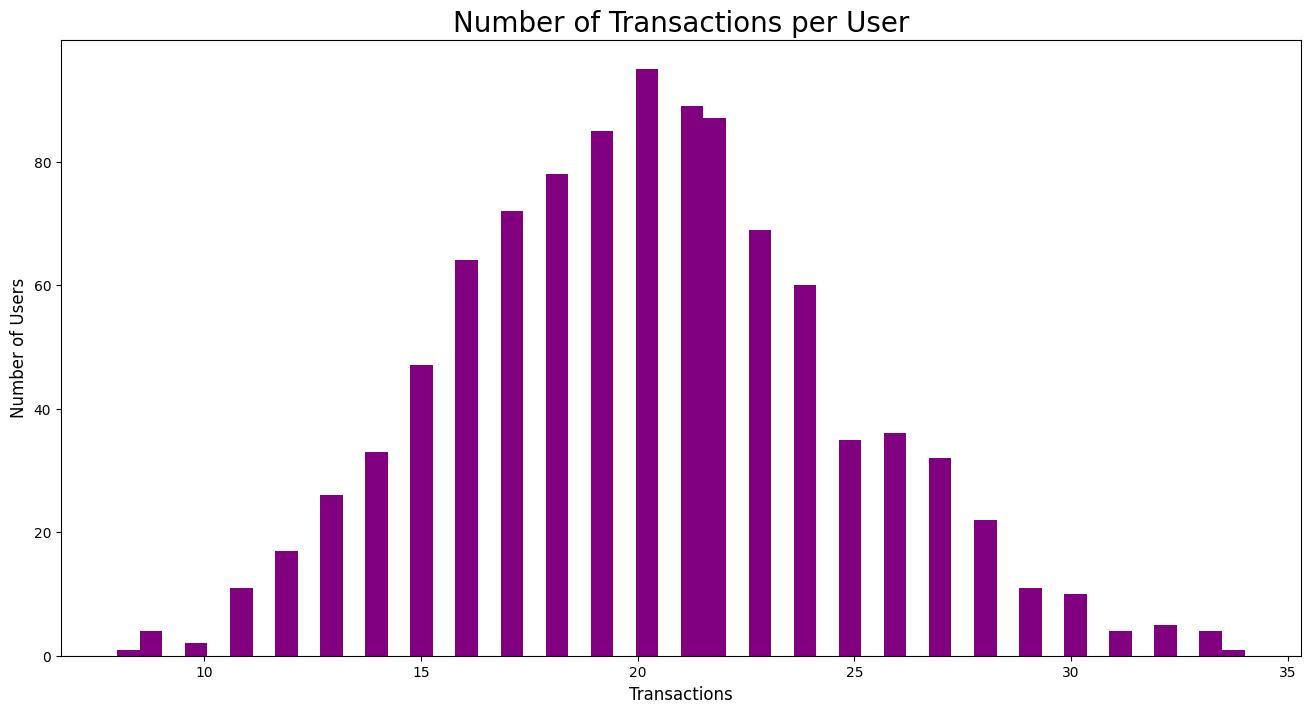

In [85]:
# Group the transactions by customer and count the number of transactions for each customer
transactions_per_user = df_historical.groupby('customer_id').size().reset_index(name='transaction_count')

# Show the distribution of transactions per user
plt.figure(figsize=(16, 8))
plt.hist(transactions_per_user['transaction_count'], bins=50, color='purple')
plt.title('Number of Transactions per User', fontsize=20)
plt.xlabel('Transactions', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

plt.show()

`Frequency of users acivity` :
- **This histogram reveals that most users were active on the platform for 7 to 9 days during the observed period, indicating strong user retention and consistent engagement. Very few users had low activity (fewer than 5 days), suggesting that once users engage, they tend to return frequently.**

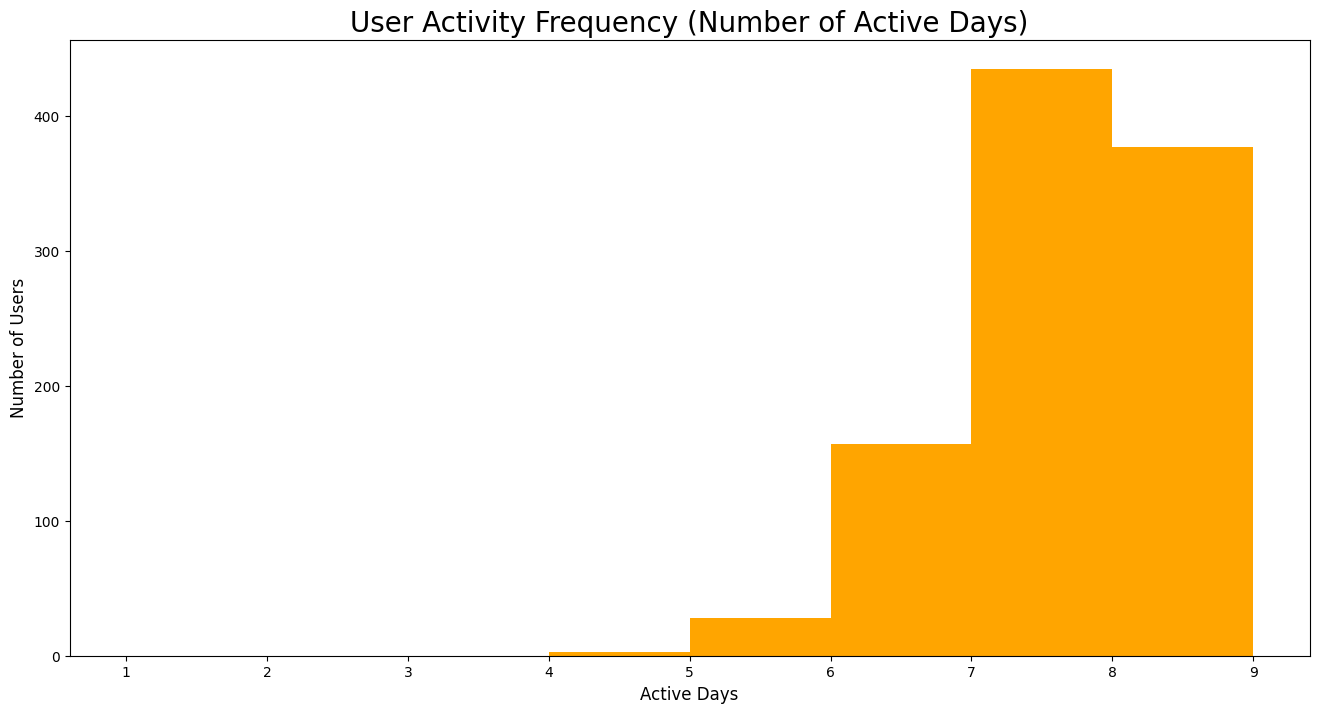

In [92]:
# Group the transactions by day and customer, and count the number of active days for each customer
active_days = df_historical.groupby(['customer_id', 'day']).size().reset_index(name='daily_count')
user_active_days = active_days.groupby('customer_id').size().reset_index(name='active_days_count')

# Convert the active days count to an integer type
user_active_days['active_days_count'] = user_active_days['active_days_count'].astype(int)

# Show
plt.figure(figsize=(16, 8))
plt.hist(user_active_days['active_days_count'], bins=range(1, user_active_days['active_days_count'].max()+2), color='orange')
plt.title('User Activity Frequency (Number of Active Days)', fontsize=20)
plt.xlabel('Active Days', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(range(1, user_active_days['active_days_count'].max()+2))

plt.show()

`Users growth trends` :
- **This chart shows that the number of daily active users rose sharply on April 24 and remained relatively high and stable throughout the week, with only slight day-to-day variations. The slight drop on April 30 could indicate either reduced user engagement or the beginning of a downward trend that should be monitored. Overall, the platform maintained strong user activity during this period.**

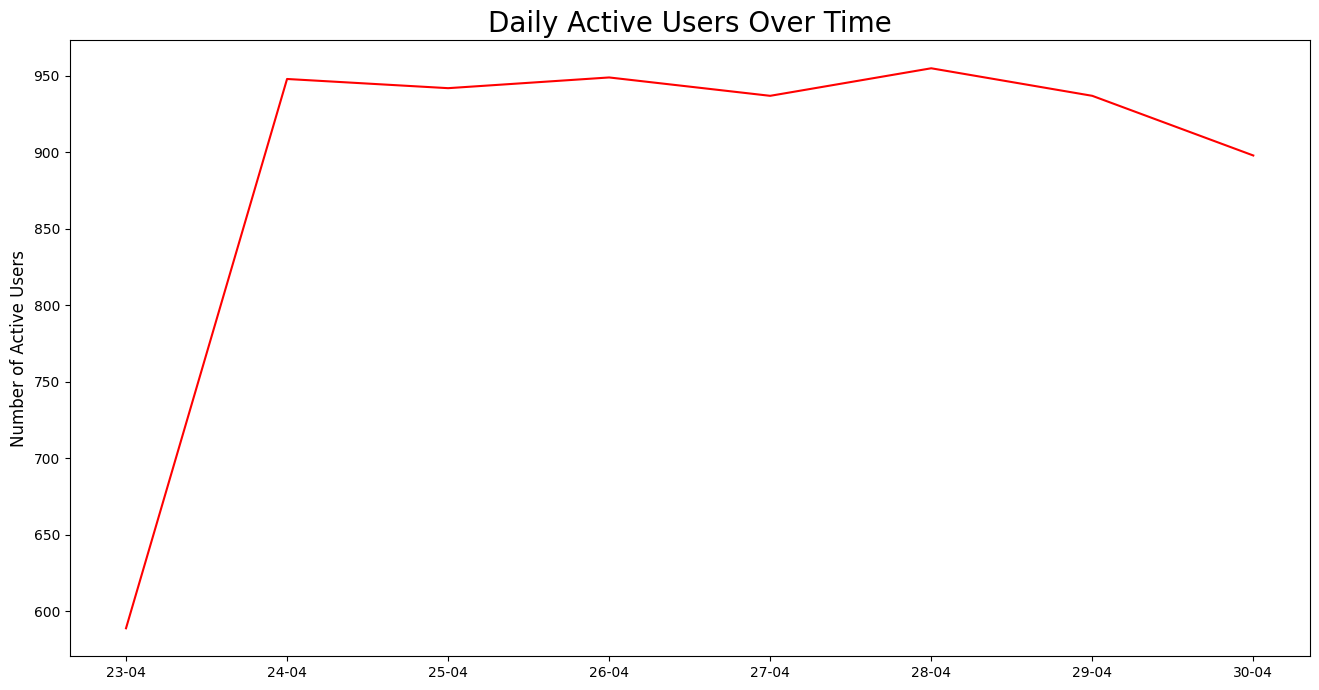

In [97]:
# Group the transactions by day and count the number of unique customers for each day
daily_active_users = df_historical.groupby('day')['customer_id'].nunique().reset_index(name='active_user_count')

# Convert the day column to a string format for better visualization
daily_active_users['day_str'] = daily_active_users['day'].apply(lambda x: x.strftime('%d-%m'))

plt.figure(figsize=(16, 8))
plt.plot(daily_active_users['day_str'], daily_active_users['active_user_count'], color='red')
plt.title('Daily Active Users Over Time', fontsize=20)
plt.ylabel('Number of Active Users', fontsize=12)

plt.show()

### 💡*Bonus Tasks*

#### I. Advanced Fraud Patterns - Temporal Analysis

1) ***Identify transactions occurring outside the merchant's local business hours.***

In [107]:
# Specify the business hours for the transactions
start_business_hour = '07:00:00'
end_business_hour = '16:00:00'

# Add a new column to the dataframe with the time part of the timestamp
df_historical['time'] = df_historical['timestamp'].dt.time

# Convert the business hours to time objects
start_time = datetime.strptime(start_business_hour, '%H:%M:%S').time()
end_time = datetime.strptime(end_business_hour, '%H:%M:%S').time()

# A function to check if a transaction is outside business hours
def is_outside_business_hours(row):
    txn_time = row['time']
    if start_time <= txn_time <= end_time:
        return False
    else:
        return True

# Apply the function to the transactions
df_historical['outside_hours'] = df_historical.apply(is_outside_business_hours, axis=1)
outside_business_txns = df_historical[df_historical['outside_hours'] == True]

# Show the results
print(outside_business_txns[['merchant_id', 'timestamp']].head().to_string(index=False))

merchant_id                        timestamp
   merch_49 2025-04-24 22:24:29.851410+00:00
   merch_26 2025-04-29 21:08:44.267608+00:00
    merch_5 2025-04-29 05:38:58.736436+00:00
    merch_5 2025-04-27 23:18:43.361378+00:00
   merch_44 2025-04-26 01:01:04.555184+00:00


2) ***Identify which part of the day, each merchant category is most active.***

In [106]:
# A function to get the time segment of the day
def get_time_segment(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Add a new column to the dataframe with the hour part of the timestamp
df_historical['hour'] = df_historical['timestamp'].dt.hour

# Apply the function to get the time segment
df_historical['day_segment'] = df_historical['hour'].apply(get_time_segment)

# Group the transactions by merchant category and time segment, and count the number of transactions for each segment
activity = df_historical.groupby(['merchant_category', 'day_segment']).size().reset_index(name='txn_count')

# Select the Most active segmant days for each merchant category
peak_times = activity.sort_values('txn_count', ascending=False).drop_duplicates('merchant_category')

# Show the results
print(peak_times.to_string(index=False))

merchant_category day_segment  txn_count
   transportation       Night       1400
       government       Night       1345
     food_service       Night       1312
           retail       Night       1272
    entertainment       Night       1245


3) ***Identify merchants whose business faces sudden transaction spikes.***

In [119]:
# Compute number of transactions for each merchant
user_txn_count = df_historical.groupby('merchant_id').size().reset_index(name='txn_count')

# Calculate average of transactions of all merchants
mean_txns = user_txn_count['txn_count'].mean()

# Spkie: Number of transactions more than of the mean
spike_users = user_txn_count[user_txn_count['txn_count'] > (1 * mean_txns)]

# Show the results
print(spike_users)

   merchant_id  txn_count
1     merch_10        415
5     merch_14        436
6     merch_15        416
7     merch_16        430
9     merch_18        408
11     merch_2        417
13    merch_21        418
15    merch_23        405
16    merch_24        430
18    merch_26        432
19    merch_27        412
20    merch_28        414
25    merch_32        405
26    merch_33        428
29    merch_36        416
30    merch_37        410
32    merch_39        405
38    merch_44        405
40    merch_46        423
41    merch_47        444
42    merch_48        418
44     merch_5        430
45    merch_50        406
46     merch_6        409
48     merch_8        446
49     merch_9        416


#### II. Commission Audit System - Dynamic Pricing Simulator

1) ***Create PySpark UDF to recommend optimal commission type per transaction.***

In [ ]:
# # Build a new Spark session
# spark_udf = SparkSession.builder \
#     .appName('Commission Recommendation') \
#     .getOrCreate()

# # Read the transactions from the CSV file into a Spark dataframe
# df_udf = spark_udf.read.option('header', True) \
#         .option('inferSchema', True) \
#         .csv('transactions.csv')

# A User Defined Function to specify the best commission type
def recommend_commission(amount):
    # Flat
    flat_profit = 2

    # Progressive
    if amount <= 10_0000:
        progressive_profit = 0.03 * amount
    elif amount <= 50_0000:
        progressive_profit = 0.05 * amount
    else:
        progressive_profit = 0.07 * amount

    # Tiered:
    if amount <= 50_0000:
        tiered_profit = 0.05 * amount
    else:
        tiered_profit = (0.05 * 500) + (0.10 * (amount - 500))

    # Choose the best profit
    max_profit = max(flat_profit, progressive_profit, tiered_profit)
    if max_profit == flat_profit:
        return 'flat'
    elif max_profit == progressive_profit:
        return 'progressive'
    else:
        return 'tiered'

# # Register UDF
# recommend_udf = udf(recommend_commission, StringType())

# Apply the UDF to the transactions
df_historical['recommended_commission'] = df_historical['amount'].apply(recommend_commission)

# Show the results
print(df_historical[['transaction_id', 'amount', 'recommended_commission']].head(10))


                         transaction_id   amount recommended_commission
0  2e1b5dcb-6f3e-47e3-b862-18c541f59005   671074                 tiered
1  045ad193-7c2c-4f04-97ff-44f037223997   150204            progressive
2  0ae07577-7f06-4739-ac97-465d83cdd94c  1043644                 tiered
3  1bce1591-8a32-4957-a7e4-87add226acb3  1819342                 tiered
4  f842802c-4f6c-47a1-bafc-df3bf08a7f50    78966                 tiered
5  d2705311-fc48-46e2-b2c6-84e2bf228277  1253541                 tiered
6  40184198-93b7-41c4-a984-425daeeec713  1027532                 tiered
7  8ad8e451-cef0-4dd8-bb5f-f164e8cce2f8  1409281                 tiered
8  e0f15d4f-ef47-4b11-a4ff-5b3b3b848dc9  1177325                 tiered
9  3fb13922-a7b8-4c4e-88eb-bf30aa768619   713166                 tiered


2) ***Validate against historical profitability data***

In [ ]:
# Calculate the profit marigin
df_historical['profit_margin'] = df_historical['commission_amount'] / df_historical['amount']

# Compute the mean and standard deviation of the profit margin
mean_profit = df_historical['profit_margin'].mean()
std_profit = df_historical['profit_margin'].std()

# Specify the lower and upper bounds for the profit margin
lower_bound = mean_profit - 2 * std_profit
upper_bound = mean_profit + 2 * std_profit

# Filter the transactions with profit margin outside the bounds
profitability = df_historical[
    (df_historical['profit_margin'] < lower_bound) |
    (df_historical['profit_margin'] > upper_bound)
]

# Show the results
print(profitability[['transaction_id', 'profit_margin']].head(10))


                           transaction_id  profit_margin
30   f87e9b47-e996-4486-9c7b-96fd0bd9e5ad       0.019995
64   1e470e87-752c-4845-8b38-3f44c85e26df       0.019995
125  816680a5-5d80-49d1-a437-14be4c3d1005       0.019990
138  68bc8990-1d8c-4202-a4f2-01376b996fb5       0.019990
192  ef406706-45aa-4414-8a69-d4d40d63e3ce       0.019994
211  c33cd488-ff7f-49c1-8e3b-41c79e8e5cb5       0.019991
249  dad9a87a-3866-43d9-9b8d-deb8e8266f71       0.019996
271  54f50852-8811-4a20-aa37-8265268c7119       0.019992
303  2ae0ceae-8bb1-496d-b61f-9d072f11e38d       0.019990
349  ccf50c7f-caf1-4f74-a455-aec831c7a947       0.019995


: 